In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

Global seed set to 0


In [2]:
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/Hepatocyte"
)
DIR2SAVE.mkdir(parents=True, exist_ok=True)

In [3]:
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [4]:
adata = sc.read_h5ad(
    DIR2SAVE.joinpath("Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Hepatocyte.h5ad")
)

### Leiden clustering

In [5]:
adata.uns["neighbors"]

OverloadedDict, wrapping:
	{'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'method': 'umap', 'metric': 'euclidean', 'n_neighbors': 15, 'n_pcs': 10, 'random_state': 7, 'use_rep': 'X_scVI'}}
With overloaded keys:
	['connectivities', 'distances'].

In [6]:
from collections import Counter


def clustering_leiden_resolution(adata2test, res_range):
    """
    Performs hyperparameter search for resolution in leiden clustering
    :param adata2test: AnnData frame
    :param res_range: range of values to evaluate: i.e. np.arange(0.1, 1.5, 0.05)
    """
    resolution_dict = {r: None for r in res_range}
    # vary resolution parameter and see which nb of clusters occurs more frequently
    for r in res_range:
        # load adata
        adata = adata2test.copy()
        sc.tl.leiden(adata, resolution=r, random_state=7)
        # store nb of clusters for that resolution
        resolution_dict[r] = len(set(adata.obs["leiden"]))

    # plot figure: nb clusters in fct of resolution param
    fig, ax = plt.subplots(
        nrows=1, ncols=1, sharey=False, sharex=False, dpi=DPI, figsize=(5, 4.5)
    )
    plt.scatter(resolution_dict.keys(), resolution_dict.values())
    ax.set_xlabel("Resolution")
    ax.set_ylabel("Number of clusters")
    ax.tick_params(axis="both", which="major", labelsize=FONTSIZE - 10)
    plt.show()

    # display nb of times each number of clusters occurs
    print("Frequency of NB clusters")
    print(Counter(list(resolution_dict.values())))

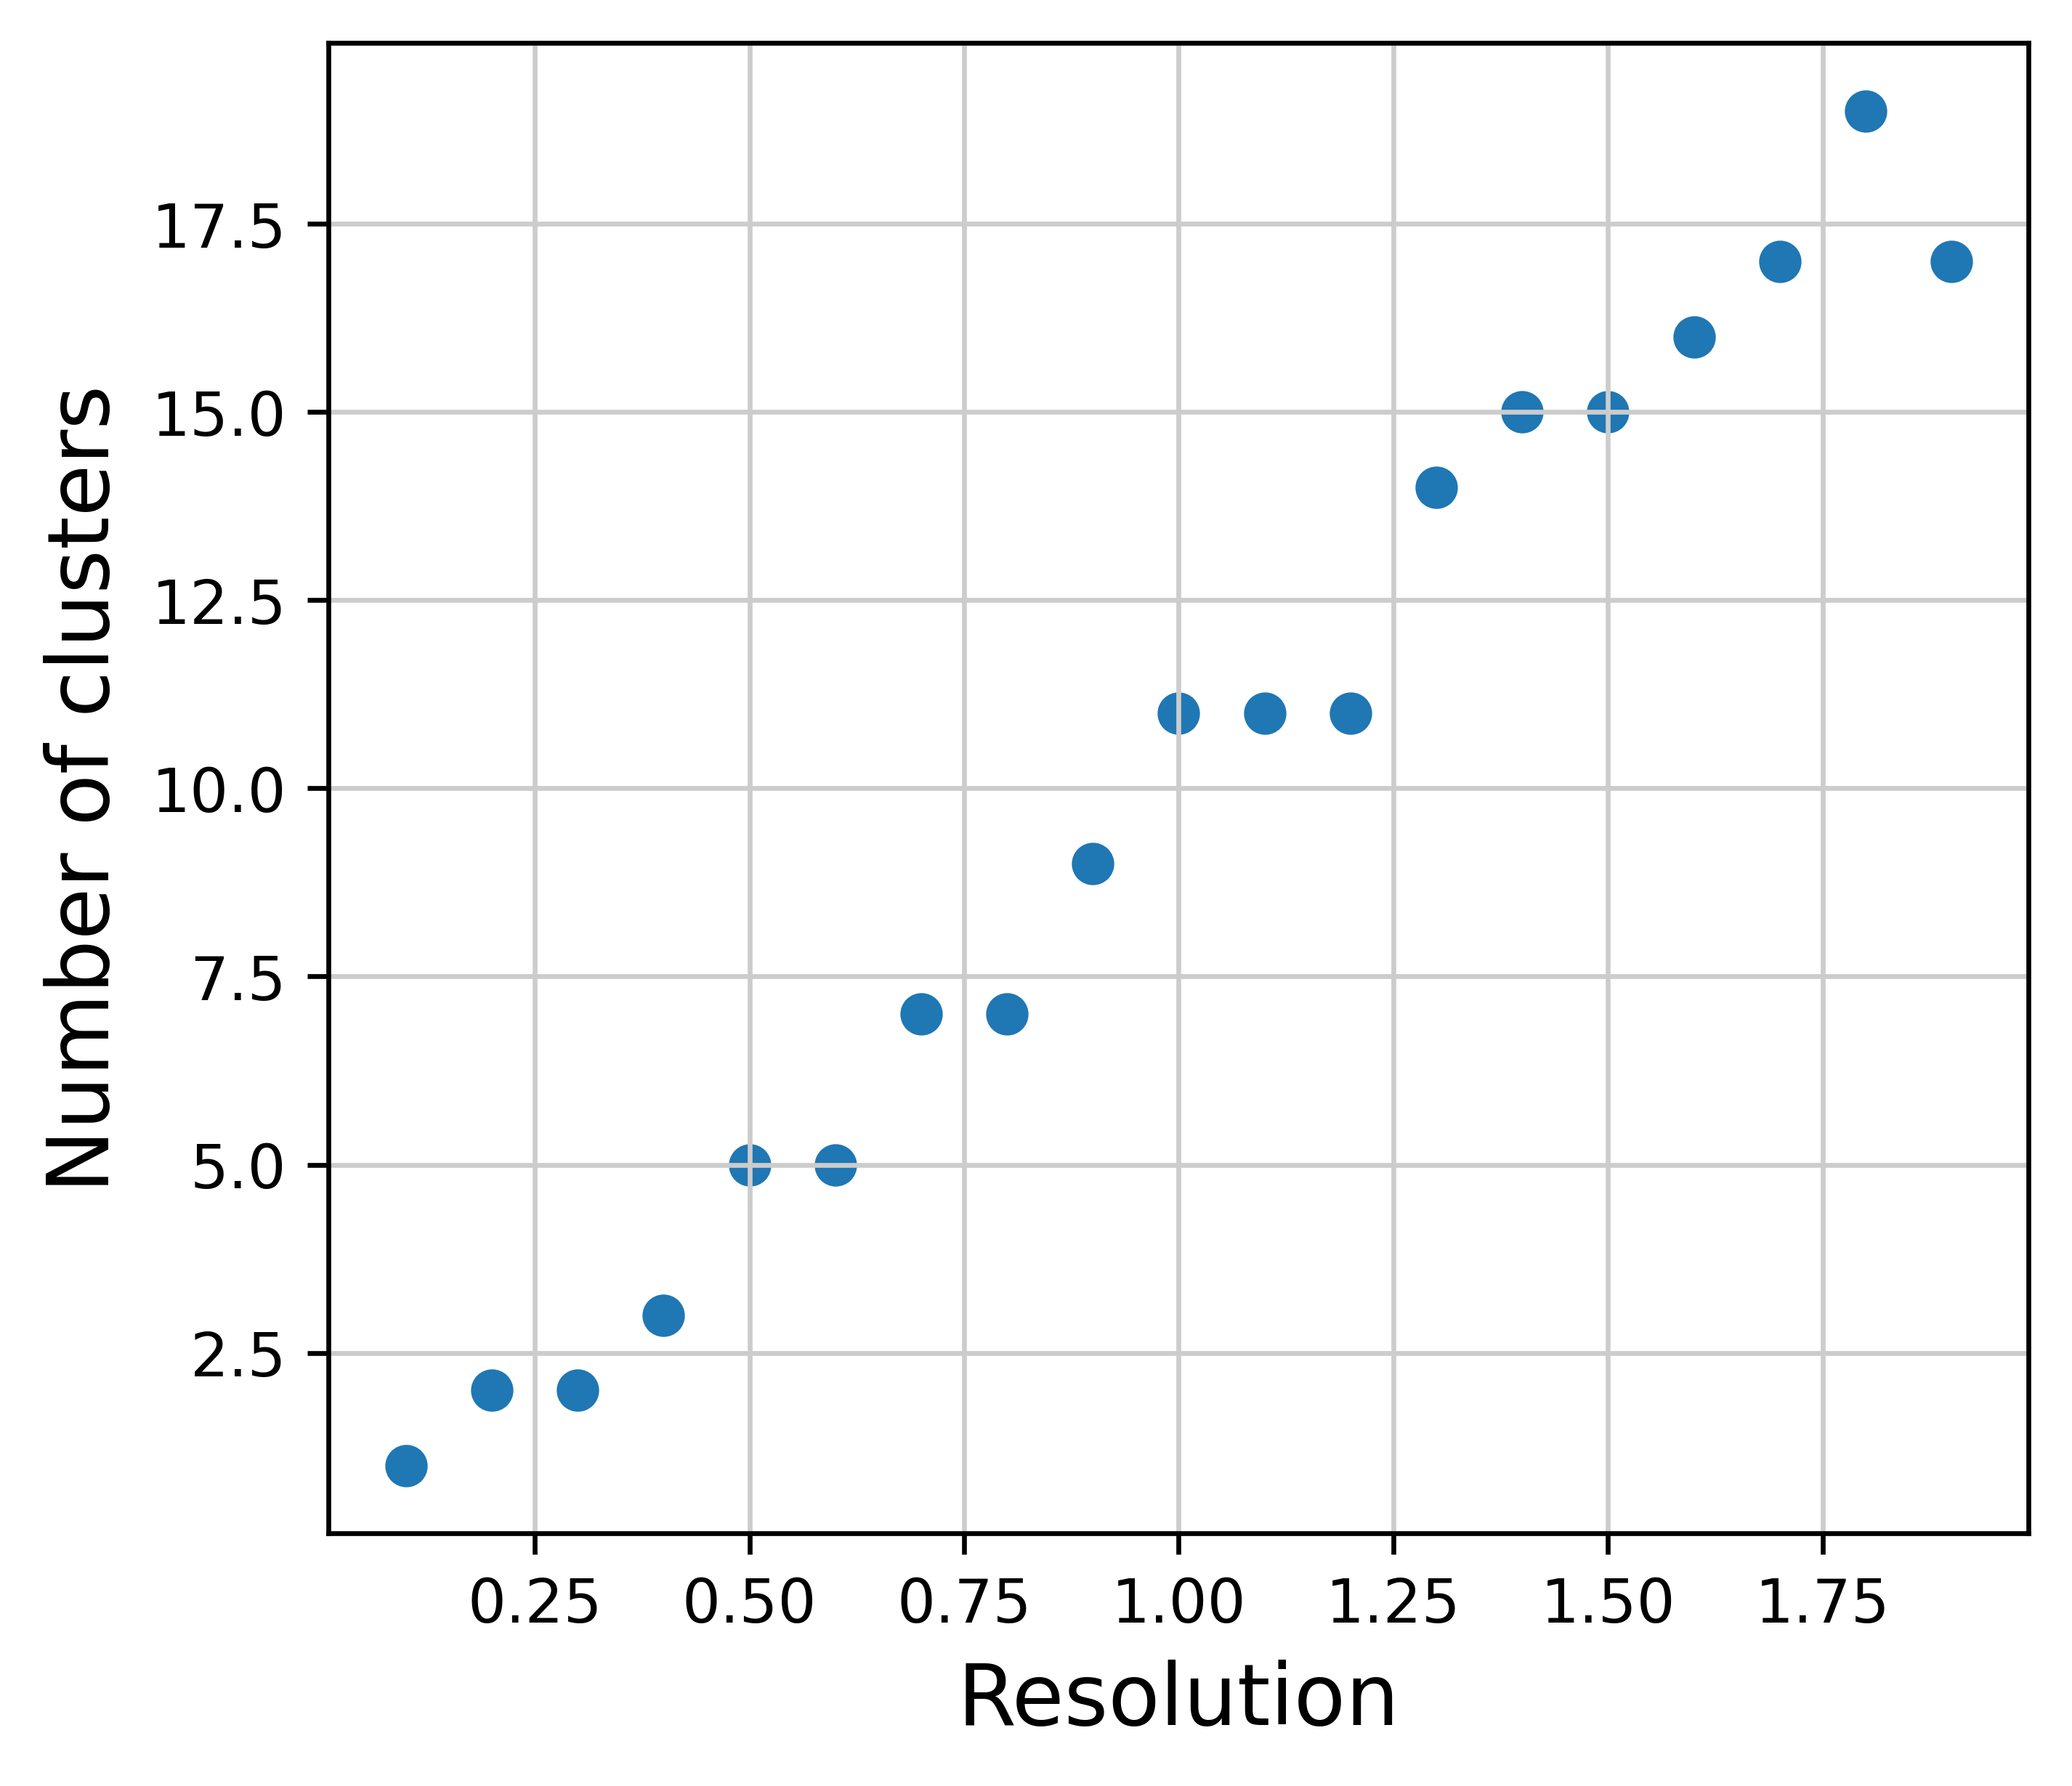

Frequency of NB clusters
Counter({11: 3, 2: 2, 5: 2, 7: 2, 15: 2, 17: 2, 1: 1, 3: 1, 9: 1, 14: 1, 16: 1, 19: 1})


In [7]:
clustering_leiden_resolution(adata, res_range=np.arange(0.1, 2, 0.1))

In [8]:
# neighbors were already computed using Harmony corrected PCs, so we perform clustering on that graph
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5, random_state=7)

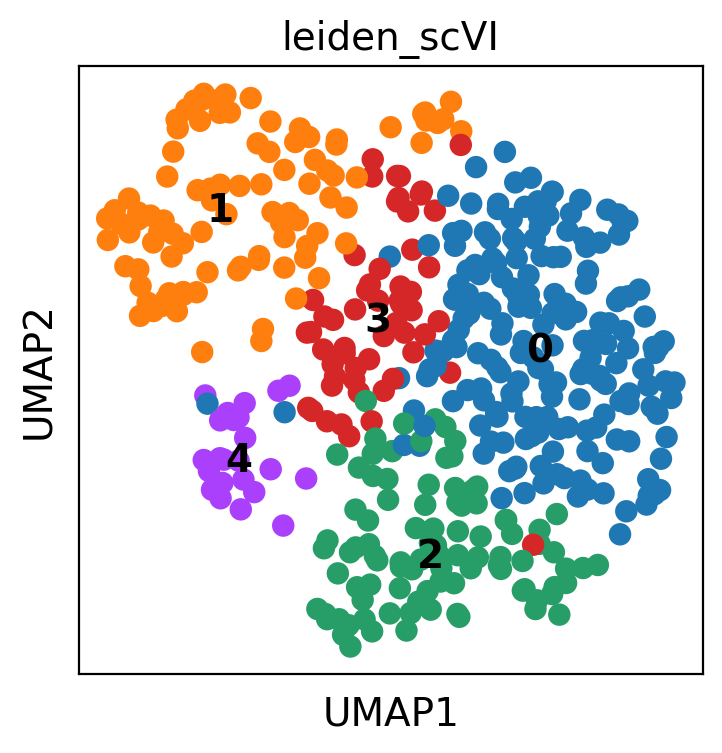

In [9]:
sc.pl.umap(
    adata,
    color="leiden_scVI",
    legend_loc="on data",
    save="general_clustering.pdf",
    show=True,
)

In [10]:
adata.obs.leiden_scVI.value_counts()

0    189
1     99
2     94
3     55
4     23
Name: leiden_scVI, dtype: int64

### Plot some markers 

In [27]:
markers = {
    "Hepatocyte": ["TTR", "APOA1", "AFP"],
    "Cholangiocyte": ["SOX9", "EPCAM", "KRT19", "CLDN4", "CLDN10", "FXYD2"],
    "Stem": ["LGR5", "SMOC2", "HNF4A", "ELF3"],
}

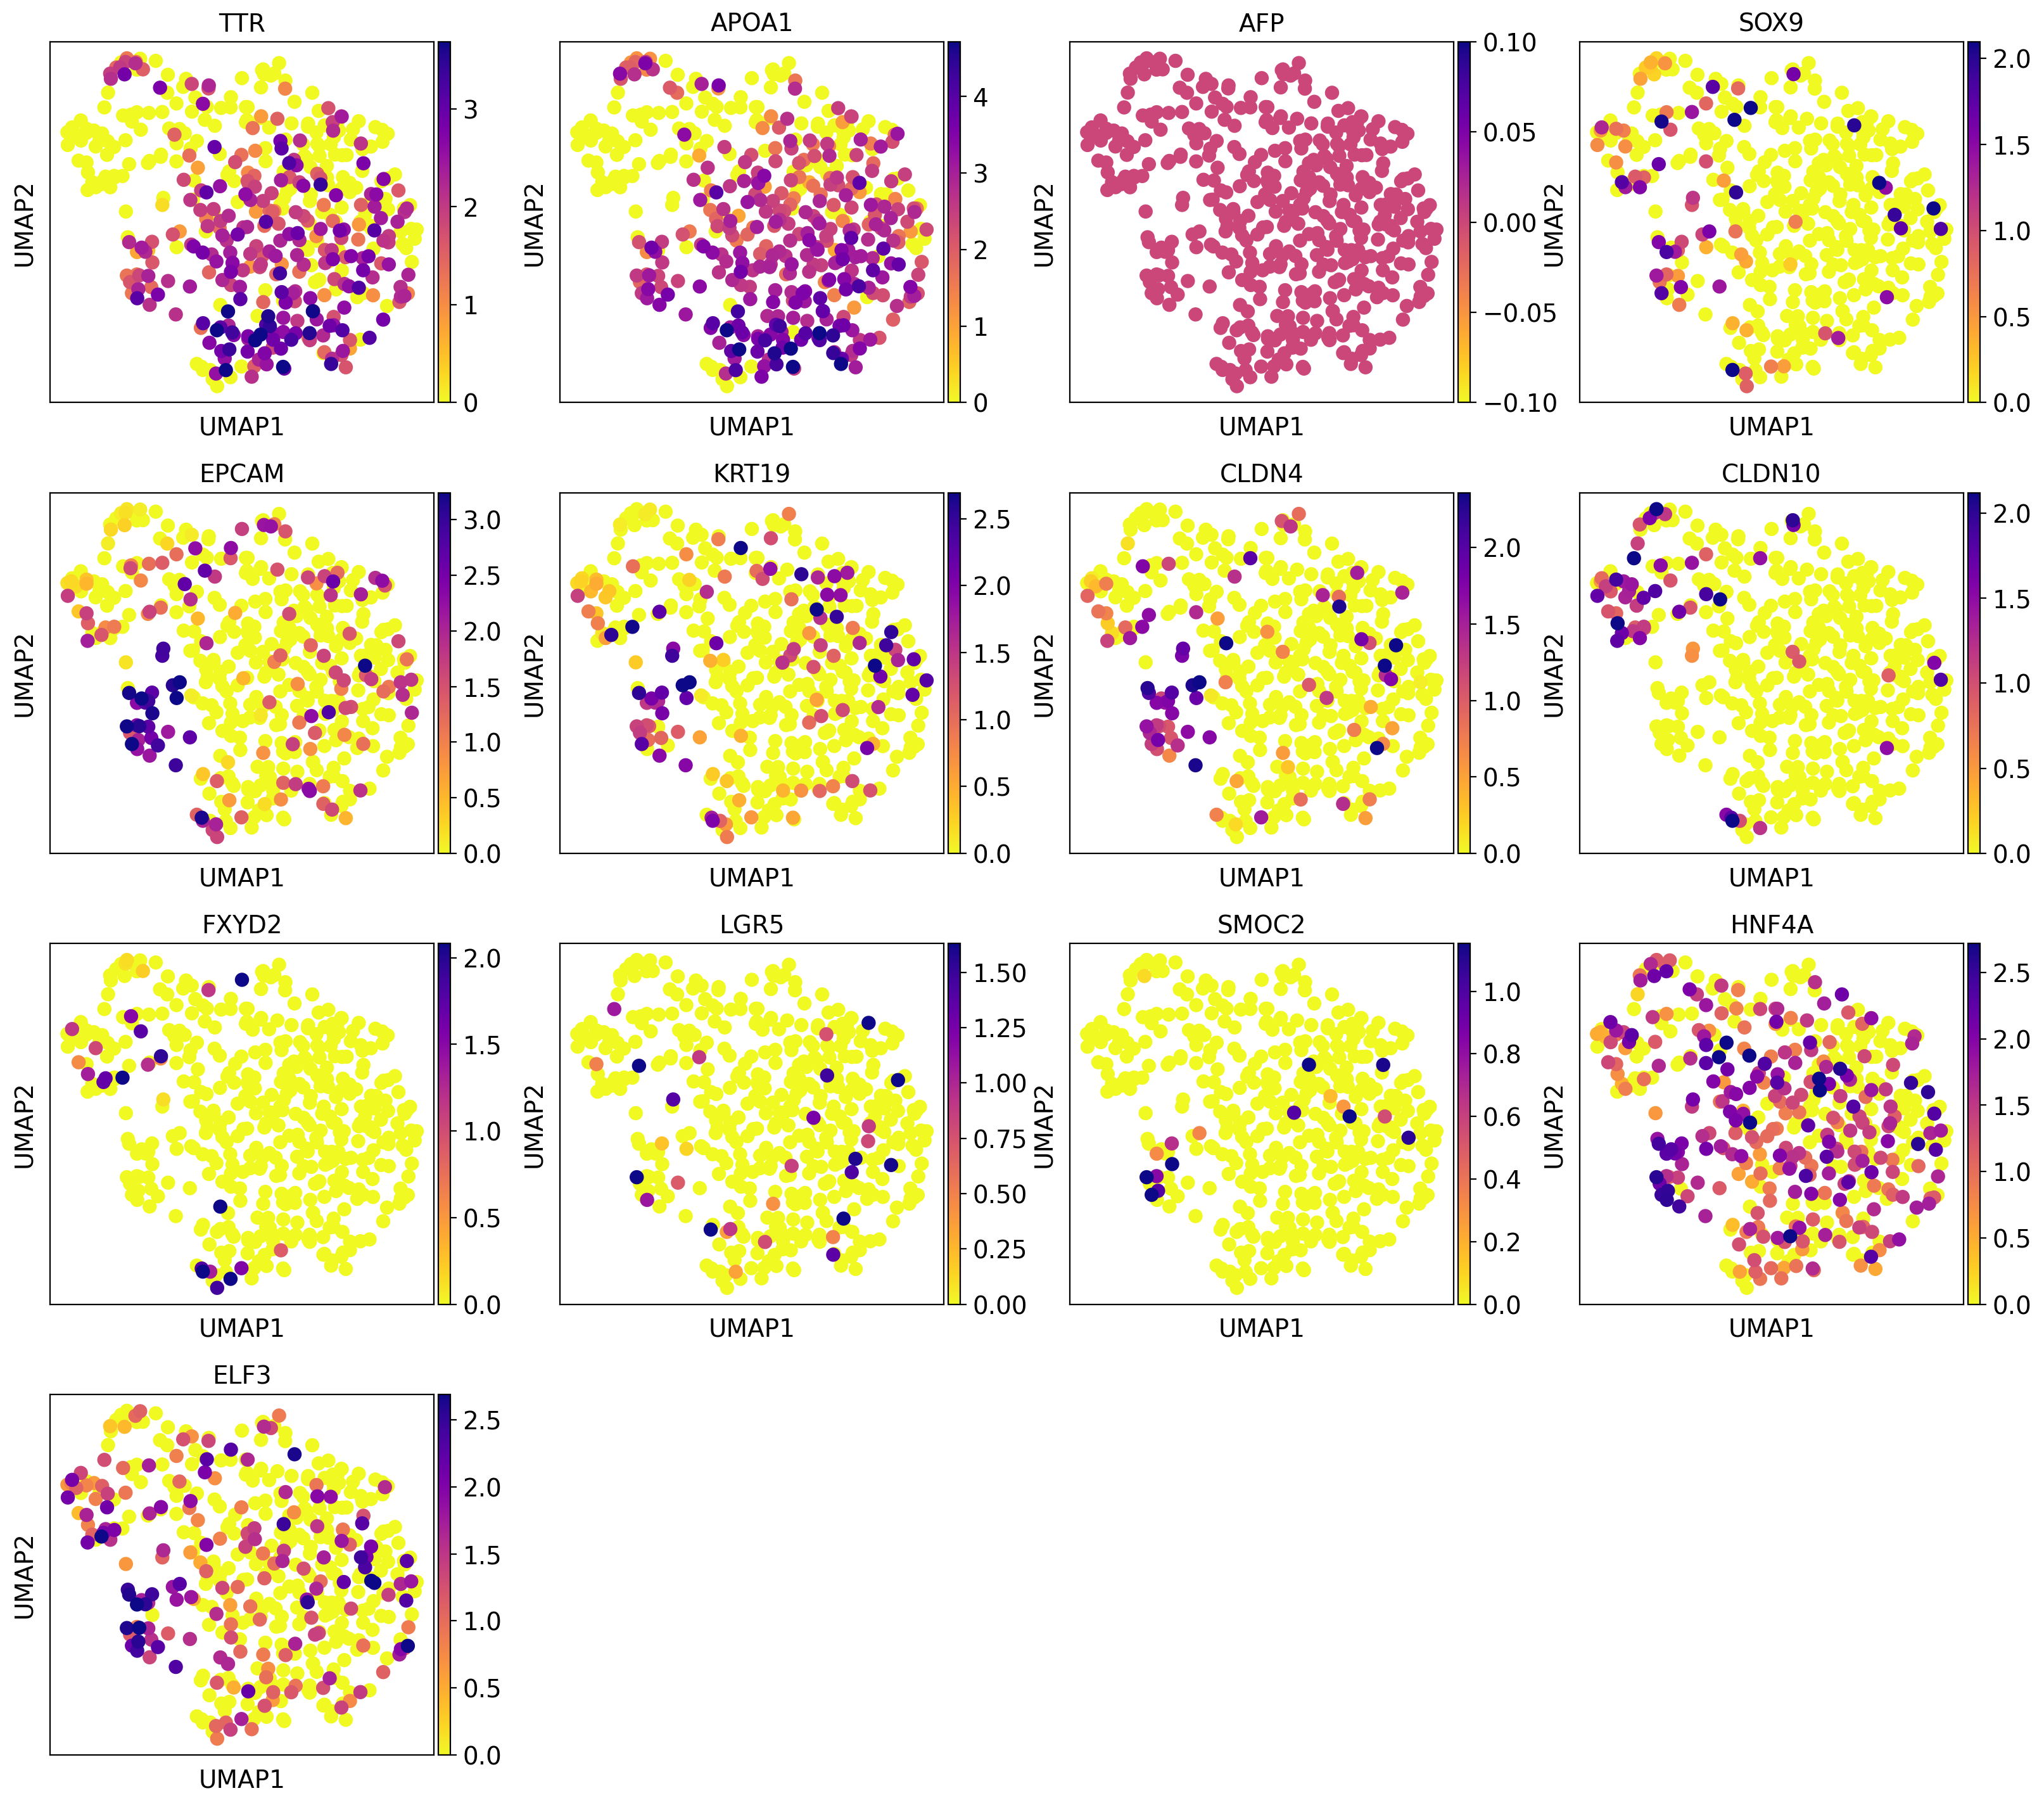

In [28]:
import itertools

# use log1p data stored in .raw
markers2plot = list(
    itertools.chain(*list(markers.values()))
)  # get all markers in a single list
sc.pl.umap(
    adata,
    color=markers2plot,
    use_raw=True,
    vmin=0.0,
    vmax="p99",
    color_map="plasma_r",  #'RdPu',
    save="general_markers.pdf",
    show=True,
)

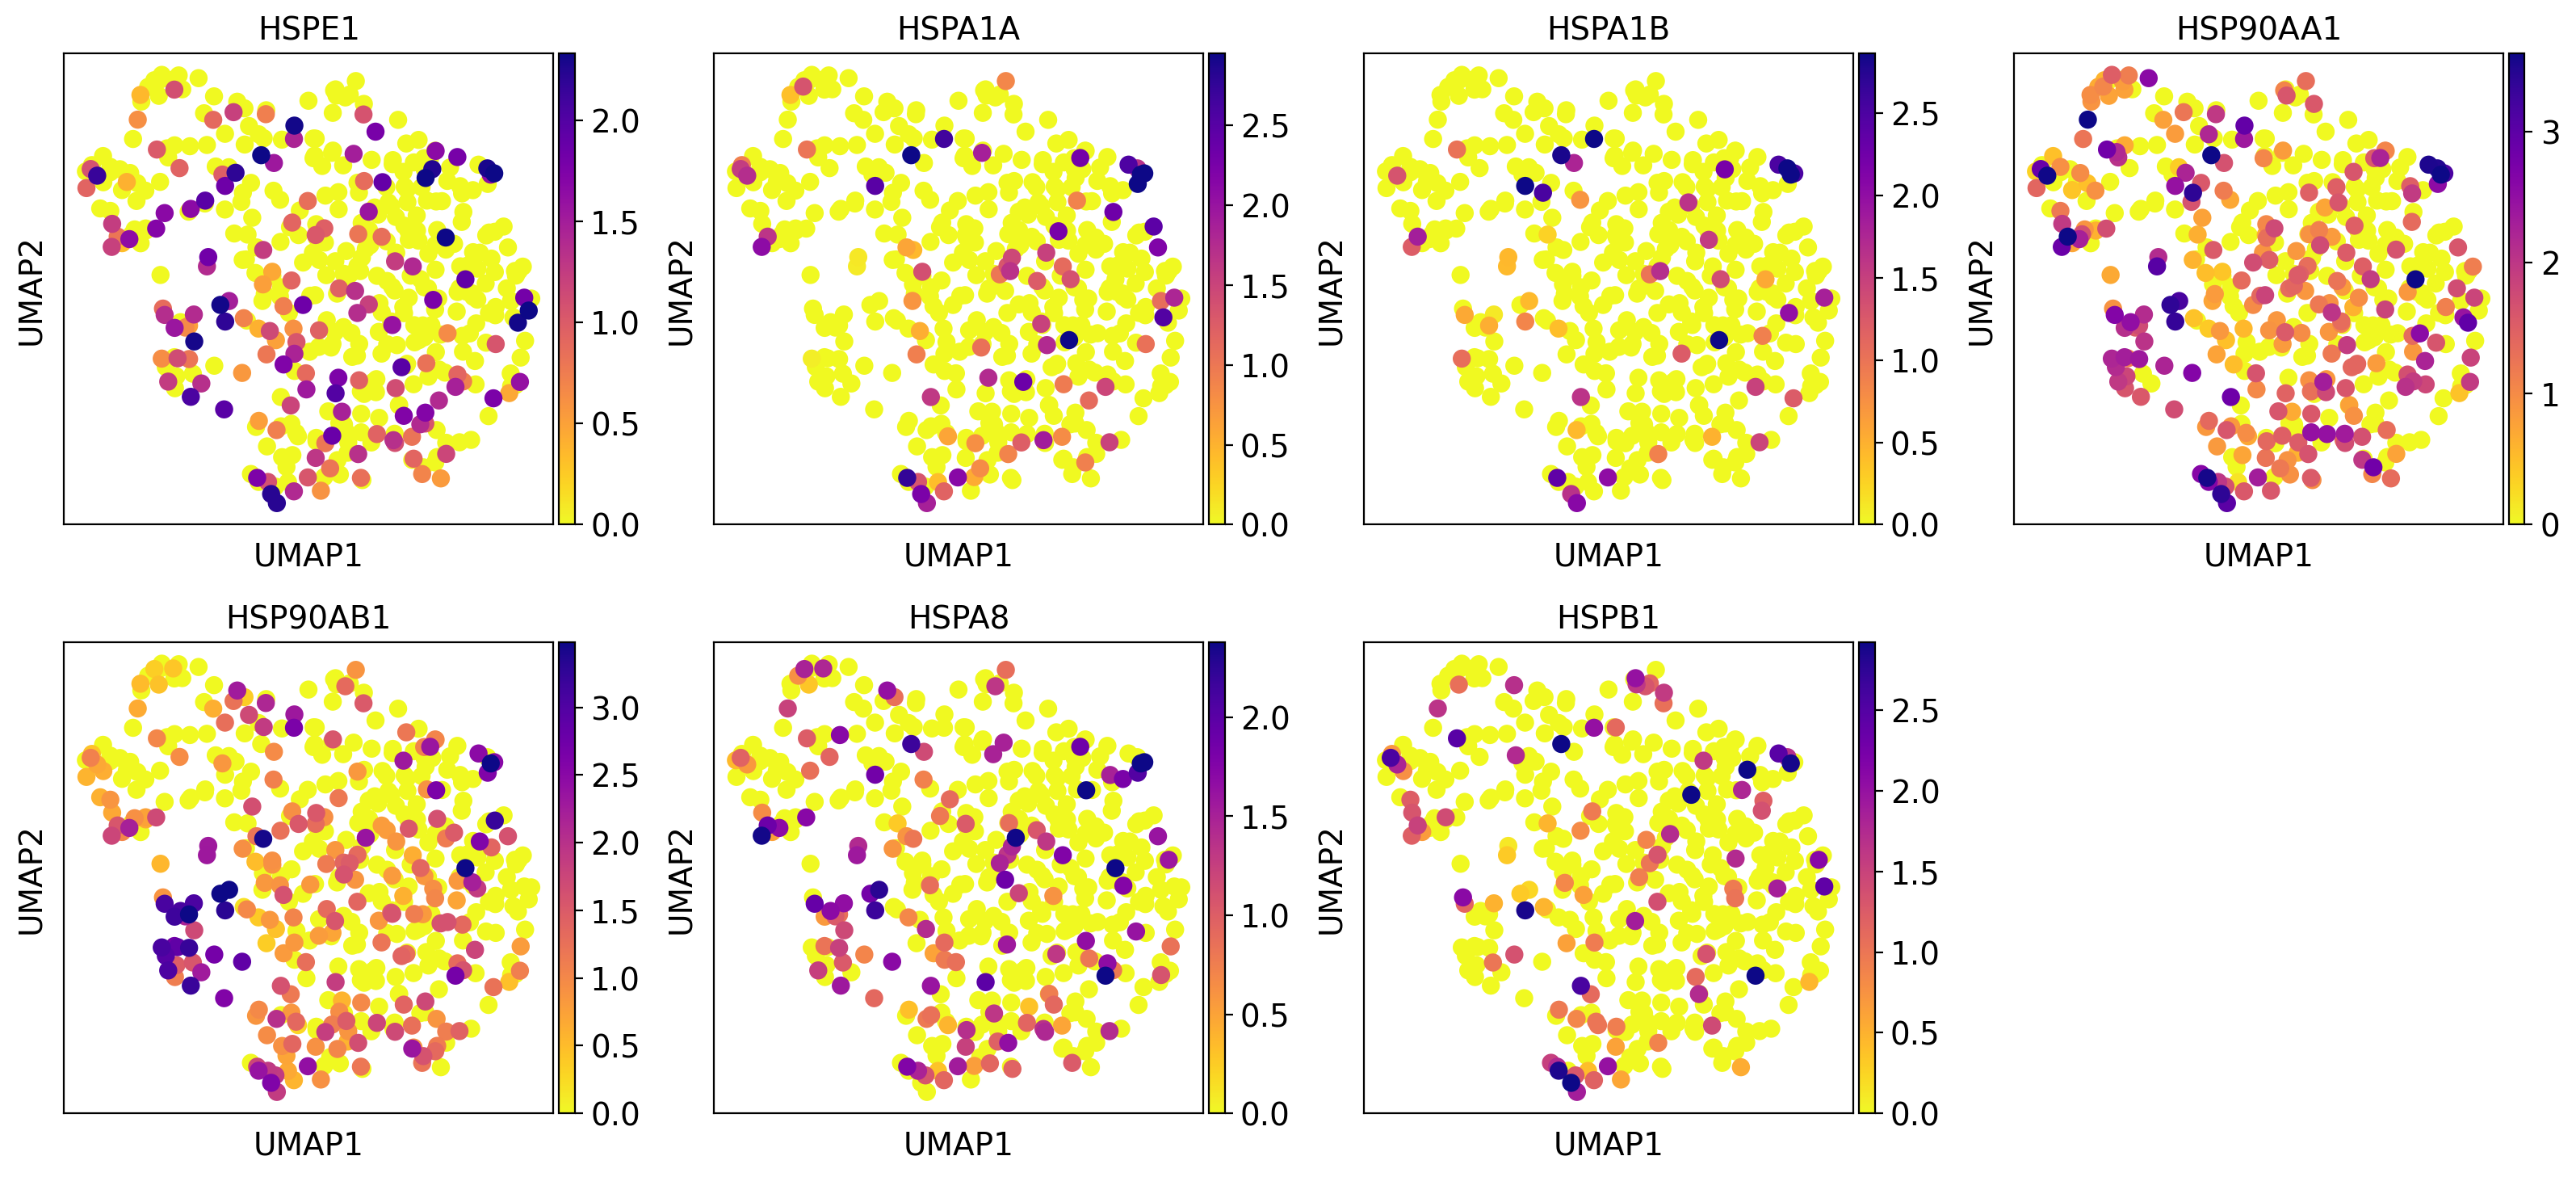

In [29]:
### markers for stress
# HSP
dissocation_markers_dict = {
    "shock protein": [
        "HSPE1",
        "HSPA1A",
        "HSPA1B",
        "HSP90AA1",
        "HSP90AB1",
        "HSPA8",
        "HSPB1",
    ],
    "immediate early genes": ["FOS", "JUN"],
}

sc.pl.umap(
    adata,
    color=dissocation_markers_dict["shock protein"],
    vmax="p99",
    use_raw=True,
    vmin=0,
    color_map="plasma_r",
    save="general_HSPmarkers.pdf",
    show=True,
)

#### these cells seem to be contamination of epithelial cells (EPCAM, stem, HSP)

In [18]:
adata[adata.obs.leiden_scVI == "4"].obs.index

Index(['CRC08_LM#GCTAGCTCAGTATGTT-1-BCI-Nuclei',
       'CRC13_LM#ACATAGCTCTTGACCC-1-BCI-Nuclei',
       'CRC13_LM#ACTCCTCAGTCCTTTG-1-BCI-Nuclei',
       'CRC13_LM#ATGAATGCAGCTCAAC-1-BCI-Nuclei',
       'CRC13_LM#ATGCAGGCAGCTTACA-1-BCI-Nuclei',
       'CRC13_LM#ATGGCTTAGCTCAAAC-1-BCI-Nuclei',
       'CRC13_LM#CGATTGAGTGTGTGGT-1-BCI-Nuclei',
       'CRC13_LM#CTAAATGTCGCTAGTG-1-BCI-Nuclei',
       'CRC13_LM#CTCATTTAGTCACCAG-1-BCI-Nuclei',
       'CRC13_LM#CTTTCTTGTTTGGGTA-1-BCI-Nuclei',
       'CRC13_LM#GCCCGTTGTCACAAAT-1-BCI-Nuclei',
       'CRC13_LM#GCCTTGCGTTTGGCGG-1-BCI-Nuclei',
       'CRC13_LM#GCGAAGTAGCATTTCT-1-BCI-Nuclei',
       'CRC13_LM#GGCTAGTGTTATCCTA-1-BCI-Nuclei',
       'CRC13_LM#GGGTGAAGTTAGCGTA-1-BCI-Nuclei',
       'CRC13_LM#GGTCTTGAGACCATAC-1-BCI-Nuclei',
       'CRC13_LM#GTACTTAAGTAAAGGT-1-BCI-Nuclei',
       'CRC13_LM#GTAGGCGAGAAACTGG-1-BCI-Nuclei',
       'CRC13_LM#GTGCGCAGTGTTAGCA-1-BCI-Nuclei',
       'CRC13_LM#TACTGACAGGCGCTAC-1-BCI-Nuclei',
       'CRC13_LM#TCG

### Differential expression to get DE genes upregulated per cluster 

In [19]:
# issue here https://github.com/theislab/single-cell-tutorial/issues/97
# This seems to be a scanpy bug as you can see here and here. The latter issue suggests to just add the line:
# adata.uns['log1p']["base"] = None after reading again, or downgrading to AnnData<0.8.
# Either way, this should be fixed soon by the maintenance team.
adata.uns["log1p"]["base"] = None

In [20]:
sc.tl.rank_genes_groups(
    adata,
    groupby="leiden_scVI",
    reference="rest",
    method="wilcoxon",
    use_raw=True,
    layer=None,
    pts=True,
    corr_method="benjamini-hochberg",
    key_added="rank_genes_wilcoxon",
)

categories: 0, 1, 2, etc.
var_group_labels: Hepatocyte, Cholangiocyte


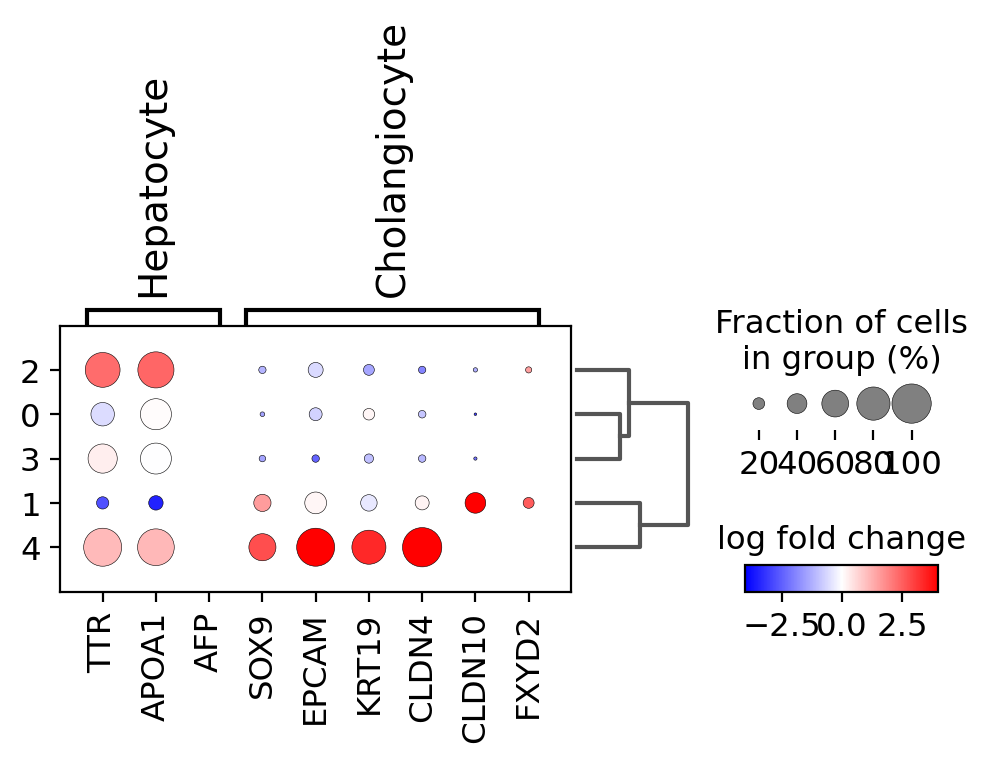

In [21]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="leiden_scVI",
    key="rank_genes_wilcoxon",
    var_names=markers,
    values_to_plot="logfoldchanges",
    cmap="bwr",
    vmin=-4,
    vmax=4,
    min_logfoldchange=1,
    colorbar_title="log fold change",
    save="general_dotplot.pdf",
    show=True,
)

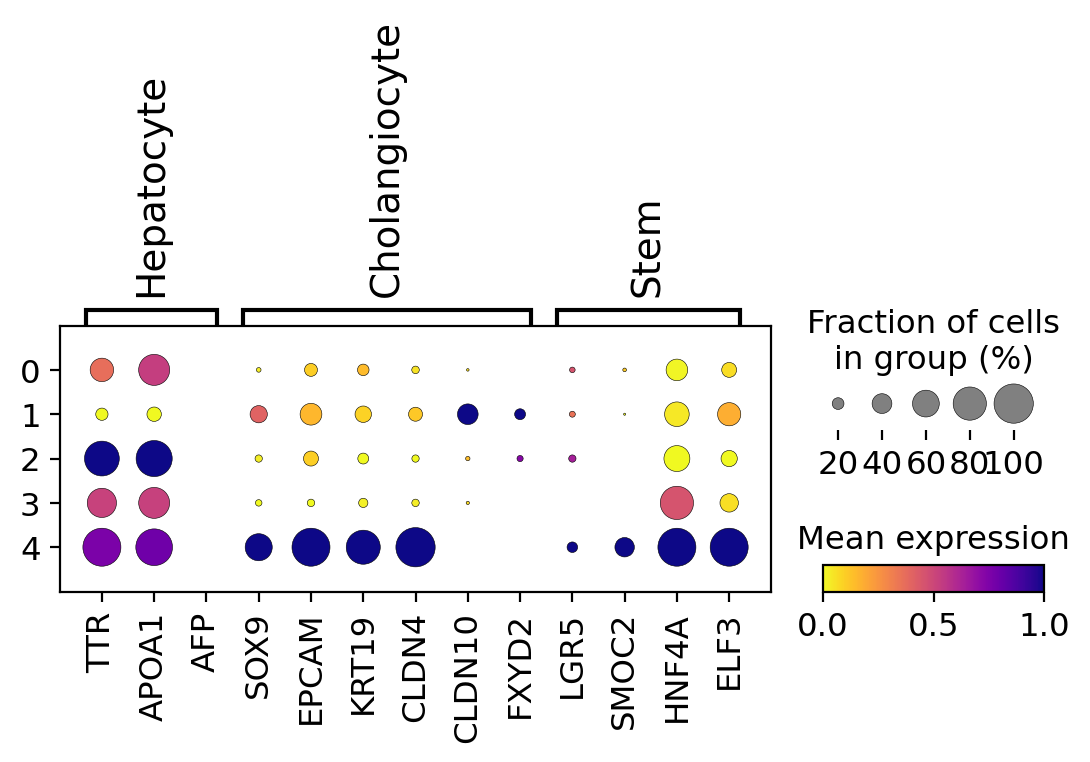

In [31]:
sc.pl.dotplot(
    adata,
    groupby="leiden_scVI",
    use_raw=True,
    var_names=markers,
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    dendrogram=False,
    save="dotplot_mean_general.pdf",
    show=True,
)

In [32]:
adata.obs.groupby(["leiden_scVI", "cell_source"]).size()

leiden_scVI  cell_source
0            BCI-Nuclei     189
1            BCI-Nuclei      99
2            BCI-Nuclei      94
3            BCI-Nuclei      55
4            BCI-Nuclei      23
dtype: int64

### Annotations

In [33]:
old_to_new = {
    "0": "Hepatocyte",
    "1": "Cholangiocyte",
    "2": "Hepatocyte",
    "3": "Hepatocyte",
    "4": "Epithelial contamination",
}

In [34]:
adata.obs["Annotation_scVI_detailed"] = (
    adata.obs["leiden_scVI"].map(old_to_new).astype("category")
)

#### change colour to label

In [35]:
# set colours for dataset, need to know order
adata.obs.Annotation_scVI_detailed.cat.categories.values.tolist()

['Cholangiocyte', 'Epithelial contamination', 'Hepatocyte']

In [5]:
adata.uns["Annotation_scVI_detailed_colors"] = ["#ccebc5", "#FB8072", "#FDB462"] 

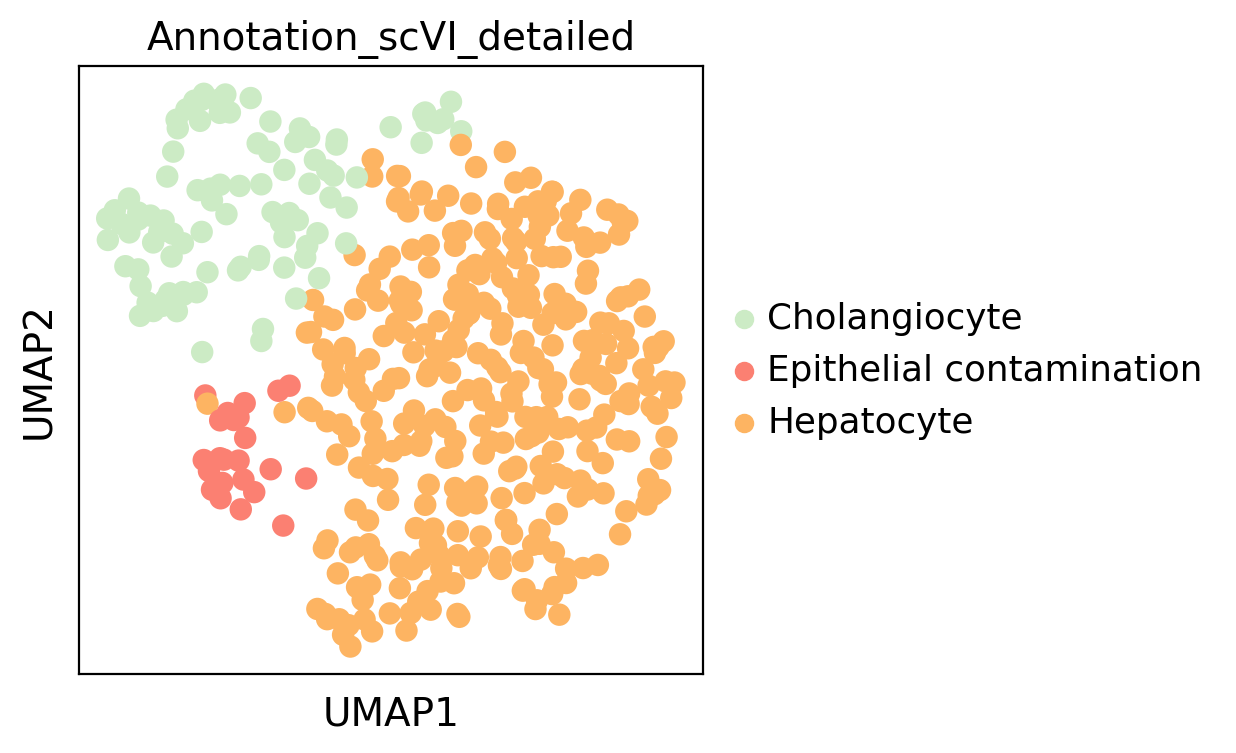

In [6]:
sc.pl.umap(
    adata,
    color="Annotation_scVI_detailed",
    show=True,
    legend_loc="right margin",
    save="annotations.pdf",
)

In [8]:
# save to file
adata.write(
    DIR2SAVE.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Hepatocyte_clustering.h5ad"
    )
)

In [7]:
adata.obs.Annotation_scVI_detailed.value_counts()

Hepatocyte                  338
Cholangiocyte                99
Epithelial contamination     23
Name: Annotation_scVI_detailed, dtype: int64

In [4]:
adata = sc.read_h5ad(
    DIR2SAVE.joinpath(
        "Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Hepatocyte_clustering.h5ad"
    )
)

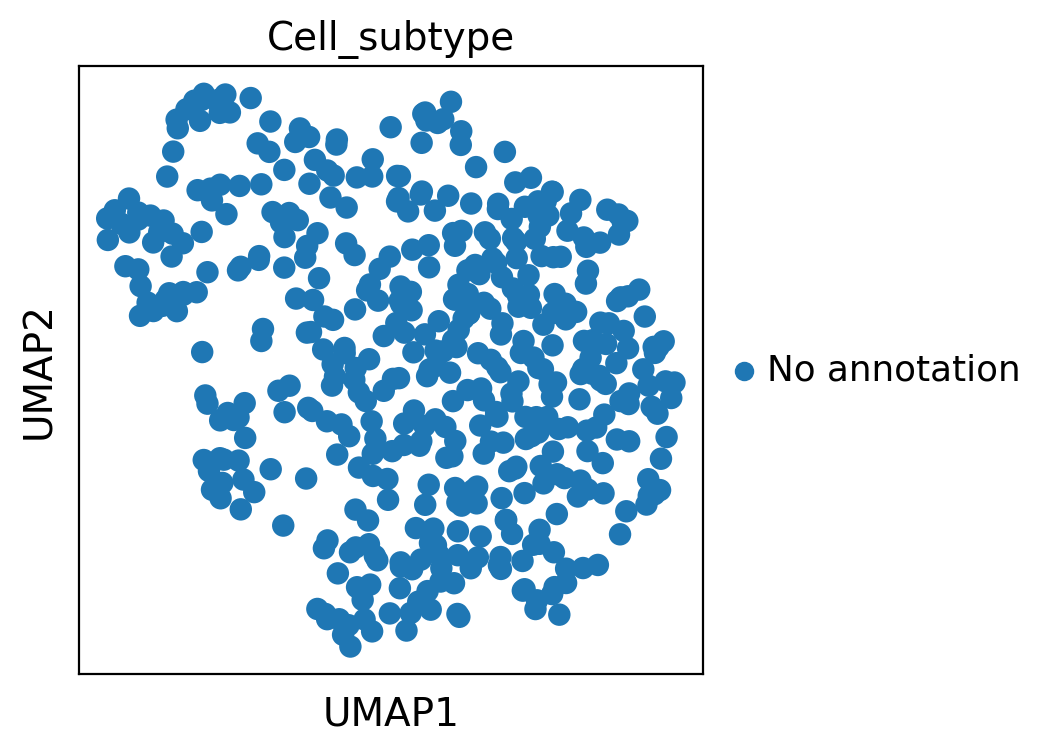

In [41]:
sc.pl.umap(adata, color="Cell_subtype")